### Samples of Optimizing Assets

This first section loads a token from a local .env file 

In [2]:
# Import relevant libraries
import sys,os
from os.path import join, dirname
from dotenv import load_dotenv

sys.path.insert(1, os.path.join(sys.path[0], '..'))  # Hack to include parent directory in search path

# Loading token, url etc from .env file in current directory
load_dotenv('.env')
token = os.environ.get("ENERGYDESK_TOKEN")
server_url = os.environ.get("ENERGYDESK_URL")
print("Using server ", server_url)

Using server  http://127.0.0.1:8001


### Initialize the Python SDK which wraps sme useful REST calls ###

In [3]:
from energydeskapi.sdk.common_utils import init_api
from energydeskapi.customers.customers_api import CustomersApi
from energydeskapi.customers.users_api import UsersApi
from energydeskapi.portfolios.portfoliotree_api import PortfolioTreeApi, PortfoliosApi
from energydeskapi.types.company_enum_types import CompanyTypeEnum, CompanyRoleEnum
import pandas as pd

api_connection=init_api()
jsdata=PortfoliosApi.get_portfolios_embedded(api_connection)
df=pd.DataFrame(data=jsdata)
print(df[['pk', 'description']])


Not setting token   Token
Token setting token  866acd8205e5ddce9c9e8738cf18dfa029a813d0 Token
    pk            description
0    1               Trader 1
1    2               Trader 2
2    3               Trader 3
3    4     Industrikontrakter
4    5               Fastpris
5    6              GoO Total
6    7   HEV Hedging Exchange
7    8  HEV Hedging Bilateral
8    9            HEV Hedging
9   10            HEV Trading
10  11              HEV Total


## Calculate dVaR ##

In [4]:
from energydeskapi.sdk.common_utils import init_api
from energydeskapi.assets.assets_api import AssetsApi
from energydeskapi.types.company_enum_types import CompanyTypeEnum, CompanyRoleEnum
import pandas as pd
import matplotlib.mlab as mlab
import numpy as np
import matplotlib
import scipy
from scipy.stats import norm
from matplotlib import pyplot as plt
from energydeskapi.risk.risk_api import RiskApi
import numpy as np
import csv
import matplotlib.pyplot as plt
import math
import random
import pandas as pd
from pyomo.opt import SolverFactory
from pyomo.core import Var
import pyomo.environ as en
import seaborn as sns
from __future__ import division
import time

%matplotlib inline

# set up seaborn the way you like
sns.set_style({'axes.linewidth': 1, 'axes.edgecolor':'black', 'xtick.direction': \
               'out', 'xtick.major.size': 4.0, 'ytick.direction': 'out', 'ytick.major.size': 4.0, \
              'axes.facecolor': 'white','grid.color': '.8', 'grid.linestyle': u'-', 'grid.linewidth': 0.5})
# Since using the data-driven data for the testing, use their battery class
from flexibility.battery import Battery
metadata = pd.read_csv('./metadata.csv', index_col=0)
metadata.head(n=2)

,Battery_1_Capacity,Battery_1_Power,Battery_1_Charge_Efficiency,Battery_1_Discharge_Efficiency,Battery_2_Capacity,Battery_2_Power,Battery_2_Charge_Efficiency,Battery_2_Discharge_Efficiency
SiteId,,,,,,,,
1,300,75.0,0.95,0.95,600,150,0.95,0.95
2,600,150.0,0.95,0.95,1200,300,0.95,0.95


In [5]:
#### CHNAGE THE SITE ID HERE
site_id = 1
parameters = metadata.loc[site_id]
batt_id = 1
# use battery class to store information
batt = Battery(capacity=parameters["Battery_"+str(batt_id)+"_Capacity"]*1000,
           charging_power_limit=parameters["Battery_"+str(batt_id)+"_Power"]*1000,
           discharging_power_limit=-parameters["Battery_"+str(batt_id)+"_Power"]*1000,
           charging_efficiency=parameters["Battery_"+str(batt_id)+"_Charge_Efficiency"],
           discharging_efficiency=parameters["Battery_"+str(batt_id)+"_Discharge_Efficiency"])
# read the testdata
testData = pd.read_csv('./submit/'+str(site_id)+'.csv',parse_dates=['timestamp'],index_col='timestamp')
# have a quick look at the testdata
testData.head()

,site_id,period_id,actual_consumption,actual_pv,load_00,load_01,load_02,load_03,load_04,load_05,...,price_sell_86,price_sell_87,price_sell_88,price_sell_89,price_sell_90,price_sell_91,price_sell_92,price_sell_93,price_sell_94,price_sell_95
timestamp,,,,,,,,,,,,,,,,,,,,,
2014-08-28 18:30:00,1,1,81176.130689,6.402769,83386.197008,67843.948781,70048.152840,59642.545109,60188.215290,59636.176826,...,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031
2014-08-28 18:45:00,1,1,80605.617963,0.000000,66806.077292,69982.725988,60119.750077,60968.213117,60585.135468,55973.870854,...,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031
2014-08-28 19:00:00,1,1,77078.004926,0.000000,74941.447951,62113.661139,61307.736184,60001.496914,54875.100794,59214.994539,...,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031
2014-08-28 19:15:00,1,1,74512.777194,0.000000,64251.265034,64877.341687,64370.170671,59689.660974,64278.362879,59704.464278,...,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031
2014-08-28 19:30:00,1,1,63425.490620,0.000000,63461.184833,62624.575734,57760.236973,62246.360804,57615.222824,56206.744732,...,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031


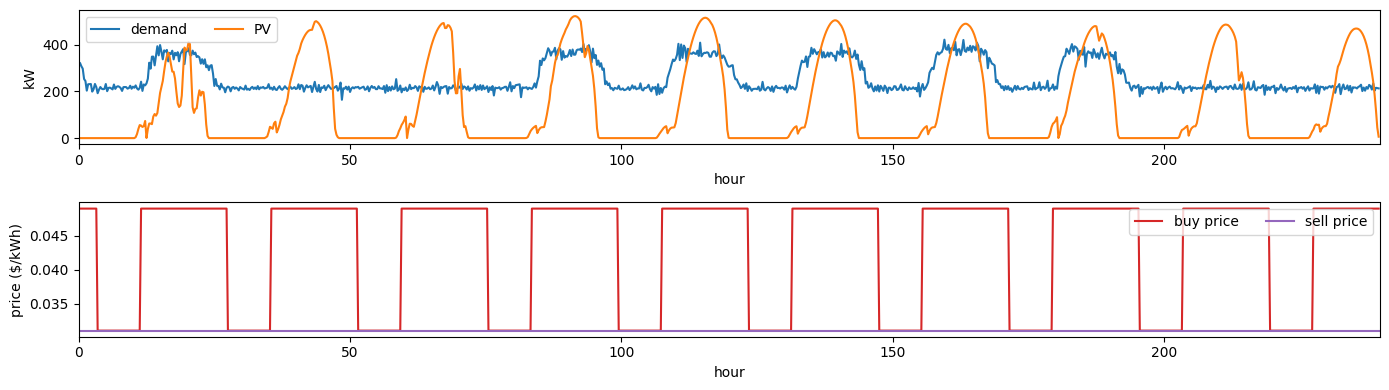

In [7]:
# lets take a look at one period
for g_id, g_df in testData.groupby('period_id'):
    break

# here convert the various timeseries to numpy arrays
# replace these with the arrays from the site you want to model
load = g_df['actual_consumption'].values
PV = g_df['actual_pv'].values
sellPrice = g_df['price_sell_00'].values
buyPrice = g_df['price_buy_00'].values

# since the last values are nan after the shift we will shorten the arrays
# shorten the arrays so the price and actual line up
load = load[0:-1]
PV = PV[0:-1]
sellPrice = sellPrice[0:-1]
buyPrice = buyPrice[0:-1]

colors = sns.color_palette()
hrs = np.arange(0,len(load))/4
fig = plt.figure(figsize=(14,4))
ax1 = fig.add_subplot(2,1,1)
l1, = ax1.plot(hrs,4*load/1000,color=colors[0])
l2, = ax1.plot(hrs,4*PV/1000,color=colors[1])
ax1.set_xlabel('hour'), ax1.set_ylabel('kW')
ax1.legend([l1,l2],['demand','PV'],ncol=2)
ax1.set_xlim([0,len(load)/4]);
ax2 = fig.add_subplot(2,1,2)
l1, = ax2.plot(hrs,buyPrice,color=colors[3])
l2, = ax2.plot(hrs,sellPrice,color=colors[4])
ax2.set_xlabel('hour'), ax2.set_ylabel('price ($/kWh)')
ax2.legend([l1,l2],['buy price','sell price'],ncol=2)
ax2.set_xlim([0,len(load)/4]);
fig.tight_layout()

In [9]:
priceDict1 = dict(enumerate(sellPrice))
priceDict2 = dict(enumerate(buyPrice))

net = load-PV
# split load into +ve and -ve
posLoad = np.copy(load-PV)
negLoad = np.copy(load-PV)
for j,e in enumerate(net):
    if e>=0:
        negLoad[j]=0
    else:
        posLoad[j]=0
posLoadDict = dict(enumerate(posLoad))
negLoadDict = dict(enumerate(negLoad))

# now set up the pyomo model
m = en.ConcreteModel()

# we use rangeset to make a sequence of integers
# time is what we will use as the model index
m.Time = en.RangeSet(0, len(net)-1) 

# variables (all indexed by Time)
m.SOC = en.Var(m.Time, bounds=(0,batt.capacity), initialize=0) #0
m.posDeltaSOC = en.Var(m.Time, initialize=0) #1
m.negDeltaSOC = en.Var(m.Time, initialize=0) #2
m.posEInGrid = en.Var(m.Time, bounds=(0,batt.charging_power_limit*(15/60.)), initialize=0) #3
m.posEInPV = en.Var(m.Time, bounds=(0,batt.charging_power_limit*(15/60.)), initialize=0) #4
m.negEOutLocal = en.Var(m.Time, bounds=(batt.discharging_power_limit*(15/60.),0), initialize=0) #5
m.negEOutExport = en.Var(m.Time, bounds=(batt.discharging_power_limit*(15/60.),0), initialize=0) #6
m.posNetLoad = en.Var(m.Time, initialize=posLoadDict) #7
m.negNetLoad = en.Var(m.Time, initialize=negLoadDict) #8

# Boolean variables (again indexed by Time)
m.Bool_char=en.Var(m.Time,within=en.Boolean) #9
m.Bool_dis=en.Var(m.Time,within=en.Boolean,initialize=0) #10

# parameters (indexed by time)
m.priceSell = en.Param(m.Time, initialize=priceDict1)
m.priceBuy = en.Param(m.Time, initialize=priceDict2)
m.posLoad = en.Param(m.Time, initialize=posLoadDict)
m.negLoad = en.Param(m.Time, initialize=negLoadDict)

# single value parameters
m.etaChg = en.Param(initialize = batt.charging_efficiency)
m.etaDisChg = en.Param(initialize = batt.discharging_efficiency)
m.ChargingLimit = en.Param(initialize = batt.charging_power_limit*(15/60.))
m.DischargingLimit = en.Param(initialize = batt.discharging_power_limit*(15/60.))

# objective function
def Obj_fn(m):
    return sum((m.priceBuy[i]*m.posNetLoad[i]) + (m.priceSell[i]*m.negNetLoad[i]) for i in m.Time)  
m.total_cost = en.Objective(rule=Obj_fn,sense=en.minimize)

# constraints
# first we define the constraint at each time period
def SOC_rule(m,t):
    if t==0:
        return (m.SOC[t] == m.posDeltaSOC[t]+m.negDeltaSOC[t])
    else:
        return (m.SOC[t] == m.SOC[t-1]+m.posDeltaSOC[t]+m.negDeltaSOC[t])   
# then we specify that this constraint is indexed by time
m.Batt_SOC = en.Constraint(m.Time,rule=SOC_rule)

# we use bigM to bound the problem
# boolean constraints
def Bool_char_rule_1(m,i):
    bigM=500000
    return((m.posDeltaSOC[i])>=-bigM*(m.Bool_char[i]))
m.Batt_ch1=en.Constraint(m.Time,rule=Bool_char_rule_1)
# if battery is charging, charging must be greater than -large
# if not, charging geq zero
def Bool_char_rule_2(m,i):
    bigM=500000
    return((m.posDeltaSOC[i])<=0+bigM*(1-m.Bool_dis[i]))
m.Batt_ch2=en.Constraint(m.Time,rule=Bool_char_rule_2)
# if batt discharging, charging must be leq zero
# if not, charging leq +large
def Bool_char_rule_3(m,i):
    bigM=500000
    return((m.negDeltaSOC[i])<=bigM*(m.Bool_dis[i]))
m.Batt_cd3=en.Constraint(m.Time,rule=Bool_char_rule_3)
# if batt discharge, discharge leq POSITIVE large
# if not, discharge leq 0
def Bool_char_rule_4(m,i):
    bigM=500000
    return((m.negDeltaSOC[i])>=0-bigM*(1-m.Bool_char[i]))
m.Batt_cd4=en.Constraint(m.Time,rule=Bool_char_rule_4)
# if batt charge, discharge geq zero
# if not, discharge geq -large
def Batt_char_dis(m,i):
    return (m.Bool_char[i]+m.Bool_dis[i],1)
m.Batt_char_dis=en.Constraint(m.Time,rule=Batt_char_dis)

#ensure charging efficiency is divided
def pos_E_in_rule(m,i):
    return (m.posEInGrid[i]+m.posEInPV[i]) == m.posDeltaSOC[i]/m.etaChg
m.posEIn_cons = en.Constraint(m.Time, rule=pos_E_in_rule)
# ensure discharging eff multiplied
def neg_E_out_rule(m,i):
    return (m.negEOutLocal[i]+m.negEOutExport[i]) == m.negDeltaSOC[i]*m.etaDisChg
m.negEOut_cons = en.Constraint(m.Time, rule=neg_E_out_rule)

# ensure charging rate obeyed
def E_charging_rate_rule(m,i):
    return (m.posEInGrid[i]+m.posEInPV[i])<=m.ChargingLimit
m.chargingLimit_cons = en.Constraint(m.Time, rule=E_charging_rate_rule)
# ensure DIScharging rate obeyed
def E_discharging_rate_rule(m,i):
    return (m.negEOutLocal[i]+m.negEOutExport[i])>=m.DischargingLimit
m.dischargingLimit_cons = en.Constraint(m.Time, rule=E_discharging_rate_rule)

# ensure that posEInPV cannot exceed local PV
def E_solar_charging_rule(m,i):
    return m.posEInPV[i]<=-m.negLoad[i]
m.solarChargingLimit_cons = en.Constraint(m.Time, rule=E_solar_charging_rule)
# ensure that negEOutLocal cannot exceed local demand
def E_local_discharge_rule(m,i):
    return m.negEOutLocal[i]>=-m.posLoad[i]
m.localDischargingLimit_cons = en.Constraint(m.Time, rule=E_local_discharge_rule)

# calculate the net positive demand
def E_pos_net_rule(m,i):
    return m.posNetLoad[i] == m.posLoad[i]+m.posEInGrid[i]+m.negEOutLocal[i]
m.E_posNet_cons = en.Constraint(m.Time,rule=E_pos_net_rule)

# calculate export
def E_neg_net_rule(m,i):
    return m.negNetLoad[i] == m.negLoad[i]+m.posEInPV[i]+m.negEOutExport[i]
m.E_negNet_cons = en.Constraint(m.Time,rule=E_neg_net_rule)

# set the path to the solver
# SPECIFY YOUR OWN PATH TO CPLEX OR WHATEVER OTHER SOLVER
opt = SolverFactory("cbc")

# time it for good measure
t = time.time()
results = opt.solve(m)
elapsed = time.time() - t
print ('Time elapsed:', elapsed)

Time elapsed: 0.8381807804107666


In [11]:
# now let's read in the value for each of the variables 
outputVars = np.zeros((9,len(sellPrice)))

# get the total cost
cost_without_batt = np.sum([(buyPrice[i]*posLoad[i]/1000 + sellPrice[i]*negLoad[i]/1000) for i in range(len(buyPrice))])
cost_with_batt = np.sum([(buyPrice[i]*outputVars[7,i]/1000 + sellPrice[i]*outputVars[8,i]/1000) for i in range(len(buyPrice))])

print ('Cost without battery:', cost_without_batt)
print ('Cost with battery:', cost_with_batt)
print ('Score: %.4f'%((cost_with_batt - cost_without_batt) / np.abs(cost_without_batt)))

Cost without battery: 1232.7842188623383
Cost with battery: 0.0
Score: -1.0000


SOC
posDeltaSOC
negDeltaSOC
posEInGrid
posEInPV
negEOutLocal
negEOutExport
posNetLoad
negNetLoad


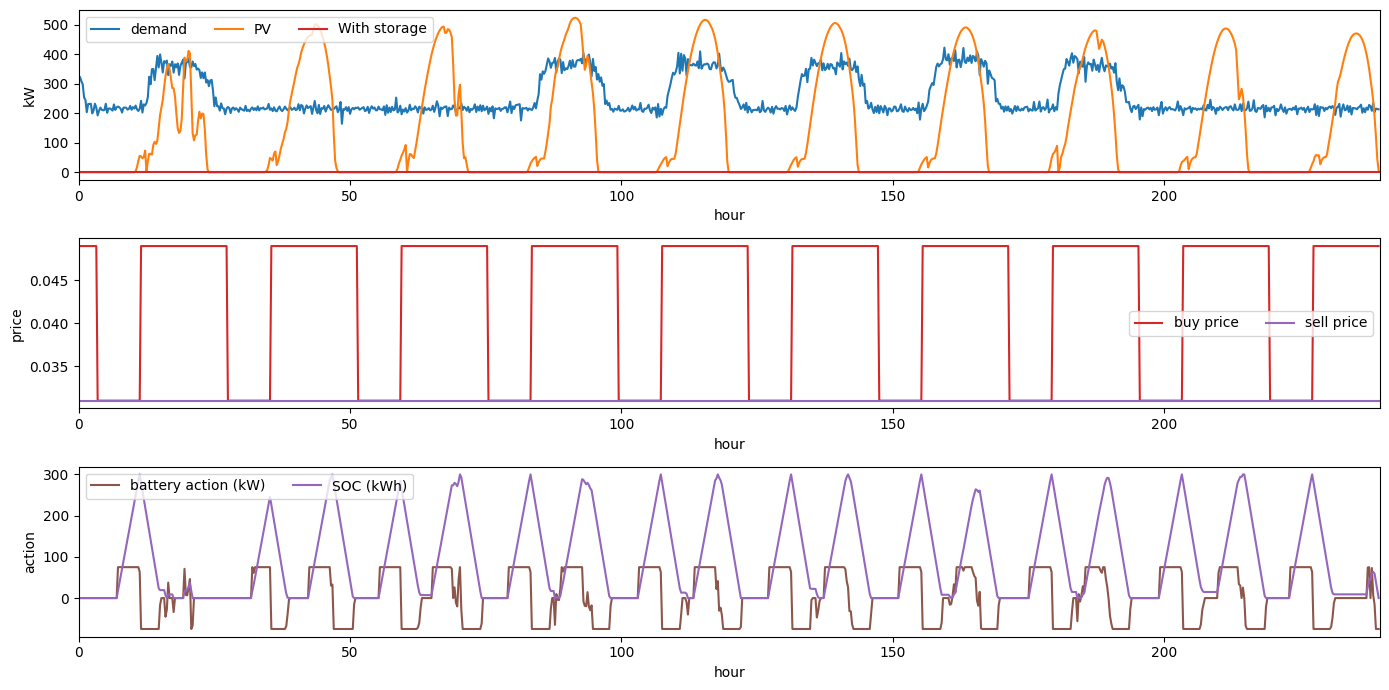

In [14]:
newNetLoad = outputVars[7]+outputVars[8]
j = 0
for v in m.component_objects(Var, active=True):
    print(v.getname())
    #print varobject.get_values()
    varobject = getattr(m, str(v))
    for index in varobject:
        outputVars[j,index] = varobject[index].value
    j+=1
    if j>=9:
        break

# lets look at the results
colors = sns.color_palette()
hrs = np.arange(0,len(load))/4
fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(3,1,1)
l1, = ax1.plot(hrs,4*load/1000,color=colors[0])
l2, = ax1.plot(hrs,4*PV/1000,color=colors[1])
l3, = ax1.plot(hrs, 4*newNetLoad/1000,color=colors[3])
ax1.set_xlabel('hour'), ax1.set_ylabel('kW')
ax1.legend([l1,l2,l3],['demand','PV','With storage'],ncol=3)
ax1.set_xlim([0,len(load)/4]);
ax2 = fig.add_subplot(3,1,2)
l1, = ax2.plot(hrs,buyPrice,color=colors[3])
l2, = ax2.plot(hrs,sellPrice,color=colors[4])
ax2.set_xlabel('hour'), ax2.set_ylabel('price')
ax2.legend([l1,l2],['buy price','sell price'],ncol=2)
ax2.set_xlim([0,len(load)/4]);
ax3 = fig.add_subplot(3,1,3)
l1, = ax3.plot(hrs,np.sum(outputVars[3:7,:]*4/1000, axis=0),color=colors[5])
l2, = ax3.plot(hrs,outputVars[0]/1000,color=colors[4])
ax3.set_xlabel('hour'), ax3.set_ylabel('action')
ax3.legend([l1,l2],['battery action (kW)','SOC (kWh)'],ncol=2)
ax3.set_xlim([0,len(load)/4]);
fig.tight_layout()